In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # save ML model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.utils import shuffle

In [2]:
def load_geo_data(geoID, disease, project_dir):
    """
    读取指定GEO ID和疾病名称的表达数据和元数据文件。

    参数：
    geoID (str): GEO ID，如 "GSE136344"
    disease (str): 疾病名称，如 "Sarcopenia"
    project_dir (str): 项目目录的路径，如 "C:/Users/dell/Documents/GitHub/osteoporosis_sarcopenia_analysis/output_degs/"

    返回：
    tuple: 表达数据 (DataFrame) 和 元数据 (DataFrame)
    """
    # 构建表达数据文件路径
    express_file = f"{project_dir}{disease}_{geoID}/{geoID}_norm_exprSet.csv"
    
    # 读取表达数据
    express_data = pd.read_csv(express_file, index_col=0).T
    
    # 构建元数据文件路径
    meta_file = f"{project_dir}{disease}_{geoID}/{geoID}_meta_info.csv"
    
    # 读取元数据
    meta_data = pd.read_csv(meta_file, index_col=0)

    # 合并表达数据和元数据
    combined_data = express_data.join(meta_data)
    
    return express_data, meta_data, combined_data


def standardize_gene_expression(combined_data):
    """
    对 combined_data 中的基因表达值进行标准化，排除最后一列的 label。

    参数：
    combined_data (DataFrame): 包含基因表达值和元数据的 DataFrame，其中最后一列是 label。

    返回：
    DataFrame: 标准化后的 combined_data
    """
    # 提取基因表达值部分（排除最后一列的 label）
    gene_expression_data = combined_data.iloc[:, :-1]
    labels = combined_data.iloc[:, -1]

    # 标准化基因表达值
    scaler = StandardScaler()
    standardized_gene_expression_data = pd.DataFrame(scaler.fit_transform(gene_expression_data), 
                                                     index   = gene_expression_data.index,
                                                     columns = gene_expression_data.columns)
    
    # 合并标准化后的基因表达值和 label
    standardized_combined_data = pd.concat([standardized_gene_expression_data, labels], axis=1)
    
    return standardized_combined_data

# 定义模型训练函数
def train_model(X_train, y_train, model_type="svm"):
    if model_type == "svm":
        model = SVC(probability=True)
    elif model_type == "random_forest":
        model = RandomForestClassifier(random_state=42)
    elif model_type == "elastic_net":
        model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
    else:
        raise ValueError("Unsupported model type. Choose from 'svm', 'random_forest', 'elastic_net'")
    
    model.fit(X_train, y_train)
    return model

# 定义模型训练函数（需要根据具体情况调整）
def train_model(X_train, y_train, model_type):
    if model_type == "svm":
        model = SVC(probability=True)
    elif model_type == "random_forest":
        model = RandomForestClassifier(random_state=42)
    elif model_type == "elastic_net":
        model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
    model.fit(X_train, y_train)
    return model

# 定义ROC曲线绘制函数
def plot_roc_curve(models, X_test, y_test, X_independent, y_independent):
    plt.figure()

    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        y_prob_ind = model.predict_proba(X_independent)[:, 1]
        fpr_ind, tpr_ind, _ = roc_curve(y_independent, y_prob_ind)
        roc_auc_ind = auc(fpr_ind, tpr_ind)

        plt.plot(fpr, tpr, lw=2, label=f'{model_name} Train (area = {roc_auc:.2f})')
        plt.plot(fpr_ind, tpr_ind, lw=2, linestyle='--', label=f'{model_name} Test (area = {roc_auc_ind:.2f})')

    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_curve_single_dataset(ax, models, X_new, y_new, dataset_name):
    # Compute ROC curves and AUC scores
    for model_name, model in models.items():
        y_new_pred_prob = model.predict_proba(X_new)[:, 1]
        fpr, tpr, _ = roc_curve(y_new, y_new_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{dataset_name}')
    ax.legend(loc="lower right")

def filter_data_by_group(combined_data, data, meta_data, group_col='group', filter_value=-1):
    """
    过滤掉 combined_data 中 group 列中值为 filter_value 的行，并同步过滤 data 和 meta_data。
    
    参数：
    combined_data (DataFrame): 合并后的数据，包括表达数据和元数据
    data (DataFrame): 原始表达数据
    meta_data (DataFrame): 原始元数据
    group_col (str): 表示 group 列的列名
    filter_value (any): 需要过滤掉的值，默认为 -1
    
    返回：
    tuple: 过滤后的 (combined_data, data, meta_data)
    """
    # 过滤 combined_data
    filtered_combined_data = combined_data[combined_data[group_col] != filter_value]

    # 获取过滤条件
    filtered_indices = filtered_combined_data.index

    # 过滤 independent_data 和 independent_meta_data
    filtered_data = data.loc[filtered_indices]
    filtered_meta_data = meta_data.loc[filtered_indices]

    # 查看过滤后的 group 列中有多少不同的类别
    group_unique_filtered = filtered_combined_data[group_col].unique()
    num_classes_filtered = len(group_unique_filtered)

    print(f"在过滤后，'{group_col}' 列中有 {num_classes_filtered} 个不同的类别：{group_unique_filtered}")
    print(filtered_combined_data.shape)
    print(filtered_data.shape)
    print(filtered_meta_data.shape)

    return filtered_combined_data, filtered_data, filtered_meta_data

In [3]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: C:\Users\dell\Documents\GitHub\osteoporosis_sarcopenia_analysis


In [4]:
# 示例用法
project_dir = "C:/Users/dell/Documents/GitHub/osteoporosis_sarcopenia_analysis/output_degs/"
#project_dir = "/Users/renjietan/Documents/GitHub/osteoporosis_sarcopenia_analysis/output_degs/"

# Sarcopenia
GSE1428_express_data, GSE1428_meta_data, GSE1428_combined_data       =  load_geo_data("GSE1428",   "Sarcopenia",   project_dir)
GSE136344_express_data, GSE136344_meta_data, GSE136344_combined_data =  load_geo_data("GSE136344", "Sarcopenia",   project_dir)
GSE362_express_data, GSE362_meta_data, GSE362_combined_data          =  load_geo_data("GSE362",    "Sarcopenia",   project_dir)

# Osteroporosis
GSE35959_express_data, GSE35959_meta_data, GSE35959_combined_data    =  load_geo_data("GSE35959",  "Osteoporosis", project_dir)
GSE56815_express_data, GSE56815_meta_data, GSE56815_combined_data    =  load_geo_data("GSE56815",  "Osteoporosis", project_dir)
GSE56814_express_data, GSE56814_meta_data, GSE56814_combined_data    =  load_geo_data("GSE56814",  "Osteoporosis", project_dir)
GSE7158_express_data,  GSE7158_meta_data,  GSE7158_combined_data     =  load_geo_data("GSE7158",   "Osteoporosis", project_dir)
GSE62402_express_data, GSE62402_meta_data, GSE62402_combined_data    =  load_geo_data("GSE62402",  "Osteoporosis", project_dir)
GSE13850_express_data, GSE13850_meta_data, GSE13850_combined_data    =  load_geo_data("GSE13850",  "Osteoporosis", project_dir)
GSE7429_express_data,  GSE7429_meta_data,  GSE7429_combined_data     =  load_geo_data("GSE7429",   "Osteoporosis", project_dir)
GSE80614_express_data, GSE80614_meta_data, GSE80614_combined_data    =  load_geo_data("GSE80614",  "Osteoporosis", project_dir)

# 打印前几行数据
print("表达数据前几行：")
print(GSE1428_express_data.head(2))

print("\n元数据前几行：")
print(GSE1428_meta_data.head(2))

# 查看 group 列中有多少不同的类别
print("\n label and shape：")
print("GSE1428:",   GSE1428_combined_data['group'].unique(),   GSE1428_combined_data.shape)
print("GSE136344:", GSE136344_combined_data['group'].unique(), GSE136344_combined_data.shape)
print("GSE35959:",  GSE35959_combined_data['group'].unique(),  GSE35959_combined_data.shape)
print("GSE56815:",  GSE56815_combined_data['group'].unique(),  GSE56815_combined_data.shape)

表达数据前几行：
              HUWE1       TPT1        CKM      TNNC2      ACTA1      MYLPF  \
GSM23735  13.868032  13.667173  13.799964  13.692127  13.617560  13.678951   
GSM23736  13.828385  13.868032  13.598277  13.647208  13.631608  13.799964   

              GAPDH        TTN       MYL1       MYL2  ...  LOC100996325  \
GSM23735  13.631608  13.921990  13.730798  13.709106  ...      1.125690   
GSM23736  13.760585  13.709106  13.692127  13.409274  ...      1.866885   

           PLEKHS1     PDE6C     NDC80  CCDC102B    ZNF674    CFAP43  \
GSM23735  1.389192  2.050302  2.050302  1.662416  1.833604  1.439007   
GSM23736  1.511813  2.409619  1.511813  0.975604  1.930616  1.203549   

             HAUS6    BPESC1     MANEA  
GSM23735  2.809860  1.389192  0.704430  
GSM23736  0.493021  0.834108  0.975604  

[2 rows x 12403 columns]

元数据前几行：
          group
sampleID       
GSM23735      0
GSM23736      1

 label and shape：
GSE1428: [0 1] (22, 12404)
GSE136344: [ 0  1 -1] (30, 12927)
GSE35959: [

In [16]:
GSE362_meta_data['group'].value_counts(dropna=False)

group
1    8
0    7
Name: count, dtype: int64

In [6]:
## Filtering data
GSE136344_combined_data, GSE136344_express_data, GSE136344_meta_data = filter_data_by_group(combined_data = GSE136344_combined_data,
                                                                                             data          = GSE136344_express_data,
                                                                                             meta_data     = GSE136344_meta_data,
                                                                                             group_col     = 'group',
                                                                                             filter_value  = -1)

在过滤后，'group' 列中有 2 个不同的类别：[0 1]
(23, 12927)
(23, 12926)
(23, 1)


In [7]:
GSE1428_std_combined_data   = standardize_gene_expression(GSE1428_combined_data)
GSE136344_std_combined_data = standardize_gene_expression(GSE136344_combined_data)
GSE362_std_combined_data    = standardize_gene_expression(GSE362_combined_data)

GSE35959_std_combined_data  = standardize_gene_expression(GSE35959_combined_data)
GSE56815_std_combined_data  = standardize_gene_expression(GSE56815_combined_data)
GSE56814_std_combined_data  = standardize_gene_expression(GSE56814_combined_data)
GSE7158_std_combined_data   = standardize_gene_expression(GSE7158_combined_data)
GSE62402_std_combined_data  = standardize_gene_expression(GSE62402_combined_data)
GSE13850_std_combined_data  = standardize_gene_expression(GSE13850_combined_data)
GSE7429_std_combined_data   = standardize_gene_expression(GSE7429_combined_data)
GSE80614_std_combined_data  = standardize_gene_expression(GSE80614_combined_data)

# 打印标准化后的数据前几行以确认
print("GSE362标准化后的数据前几行：")
print(GSE362_std_combined_data.head(2))

print("GSE136344标准化后的数据前几行：")
print(GSE136344_std_combined_data.head(2))

print("GSE35959标准化后的数据前几行：")
print(GSE35959_std_combined_data.head(2))

print("GSE56815标准化后的数据前几行：")
print(GSE56815_std_combined_data.head(2))

GSE362标准化后的数据前几行：
           RPL37A      TPT1       TTN      MYL1       CKM     TNNC1     MYLPF  \
GSM5254 -0.491198  0.538897  0.984099  0.665666 -0.653247 -0.666883  0.629863   
GSM5255 -0.117105  0.538897  0.494778  0.370451  0.748028 -1.452251  0.481346   

              SLN     TNNC2     HUWE1  ...    BPESC1      MGAM   BTF3P11  \
GSM5254  1.129971  1.154306  0.661269  ... -1.311693 -0.323830 -0.479260   
GSM5255  0.846639 -0.998074  0.845018  ... -1.404740 -0.445457  1.440228   

          SEC14L3     ASCL2    ZNF165    ZNF674    CFAP43      NRTN  group  
GSM5254 -0.715761  0.390237  1.086554 -0.343459  0.071601  0.988020      0  
GSM5255  0.866141  0.403253 -1.147917 -1.317728 -0.507659  1.515361      0  

[2 rows x 12404 columns]
GSE136344标准化后的数据前几行：
                   ACTA1  MTCO2P12       CKM   GAPDH  MTCO1P12      PYGM  \
GSM4047076 -1.776357e-15 -1.189922 -0.308877  1.0204  0.192859  0.753457   
GSM4047077 -1.776357e-15 -1.189922 -0.308877  1.0204  0.192859  2.123034   

  

In [8]:
#training_data    = pd.concat([GSE1428_std_combined_data, GSE35959_std_combined_data], axis=0)
#independent_data = pd.concat([GSE136344_std_combined_data, GSE56815_std_combined_data], axis=0)
independent_data = GSE1428_std_combined_data
training_data    = GSE136344_std_combined_data

independent_data = GSE80614_std_combined_data
training_data    = GSE35959_std_combined_data
training_data    = GSE13850_std_combined_data
training_data    = GSE56814_std_combined_data
training_data    = GSE56815_std_combined_data
training_data    = GSE62402_std_combined_data
training_data    = GSE7429_std_combined_data

training_data    = GSE80614_std_combined_data
training_data    = GSE7158_std_combined_data
training_data    = GSE56815_std_combined_data
#print(training_data.head(2))
#print(independent_data.head(2))
#print(GSE1428_std_combined_data.shape, GSE35959_std_combined_data.shape)
#print(training_data.shape, independent_data.shape)

selected_columns：
['BCL6', 'DDIT4', 'FLNA', 'FOXO1', 'IRS1', 'NFKBIA', 'PGK1', 'STAT3', 'group']
(80, 8) (80,) (64, 8) (16, 8)


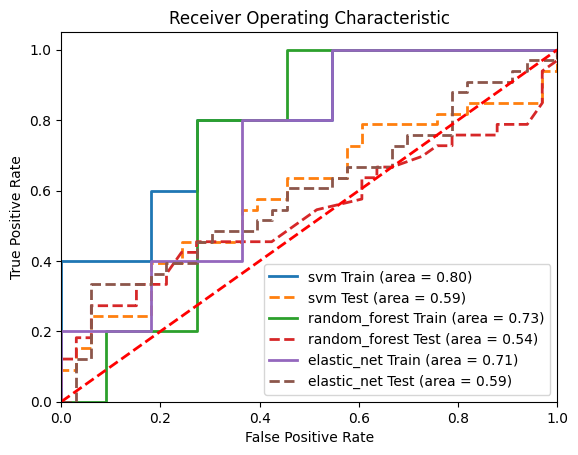

In [9]:
# 定义 hub genes
#hub_genes = ["HOXB2", "SLC38A1", "C1QA", "FEZ2", "DAAM2"] # DEGs genes for GSE1428
#hub_genes = ["NFKBIA", "CEBPB", "PSMD3", "FLNA", "AIMP2"]
#hub_genes = ["PSMD3", "NFKBIA", "CEBPB", "PSMA1", "FLNA", "AIMP2", "EIF3F", "DDIT4", "WWP1"]  #GSE1428 string+cycoscape selected
#hub_genes = ["TNF", "PTPRC", "JUN", "FGF8", "FGF18", "EGFR", "CTNNB1", "CD34", "BCL2"] #GSE56815 string+cycoscape selected
hub_genes = ["BCL6", "DDIT4", "FOXO1", "IDH1", "IRS1", "NFKBIA", "PGK1", "PKM", "STAT3"] #"FOXO3", #RRA from OS and Sa, P<0.05, FC>0 and string+cycoscape
hub_genes = ['ACLY', 'ERCC2', 'KCTD13', 'MAPK3', 'NFKB2', 'NFKBIA', 'RELB', 'TAOK2', 'TLR3']
hub_genes = ["NFKB2", "RELB", "CWC25", "MFSD10",  "ACLY", "HMGN5", "GNB2", "LAIR1", "MPPE1", "GTPBP1", "ATF1", "ZKSCAN5", "RHBDF2", "CES2"] # OS RRA freq =3 "TSNAX",
#hub_genes = ["ATP5F1C", "C1QA", "CDKN1A", "CEBPB", "DLAT", "LYVE1", "MTIF2", "PGK1", "SUCLG1", "TPI1"]  # Sa RRA freq =2 and string+cycoscape
hub_genes = ["BCL6", "DDIT4", "FLNA", "FOXO1", "IRS1", "NFKBIA", "PGK1", "STAT3"] #"FOXO3",

selected_columns = hub_genes + ['group']
print("selected_columns：")
print(selected_columns)

training_hub_data    = training_data[selected_columns]
independent_hub_data = independent_data[selected_columns]

# 打印标准化后的数据前几行以确认
#print("\nHub gene前几行：")
#print(training_hub_data.head(2))
#print("\nHub gene independent数据前几行：")
#print(independent_hub_data.head(2))

# 准备训练和测试数据
X = training_hub_data[hub_genes]
y = training_hub_data['group']
X_independent = independent_hub_data[hub_genes]
y_independent = independent_hub_data['group']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape, y.shape, X_train.shape, X_test.shape)

# 训练模型并绘制ROC曲线
models = {
    "svm": train_model(X_train, y_train, "svm"),
    "random_forest": train_model(X_train, y_train, "random_forest"),
    "elastic_net": train_model(X_train, y_train, "elastic_net")
}

plot_roc_curve(models, X_test, y_test, X_independent, y_independent)

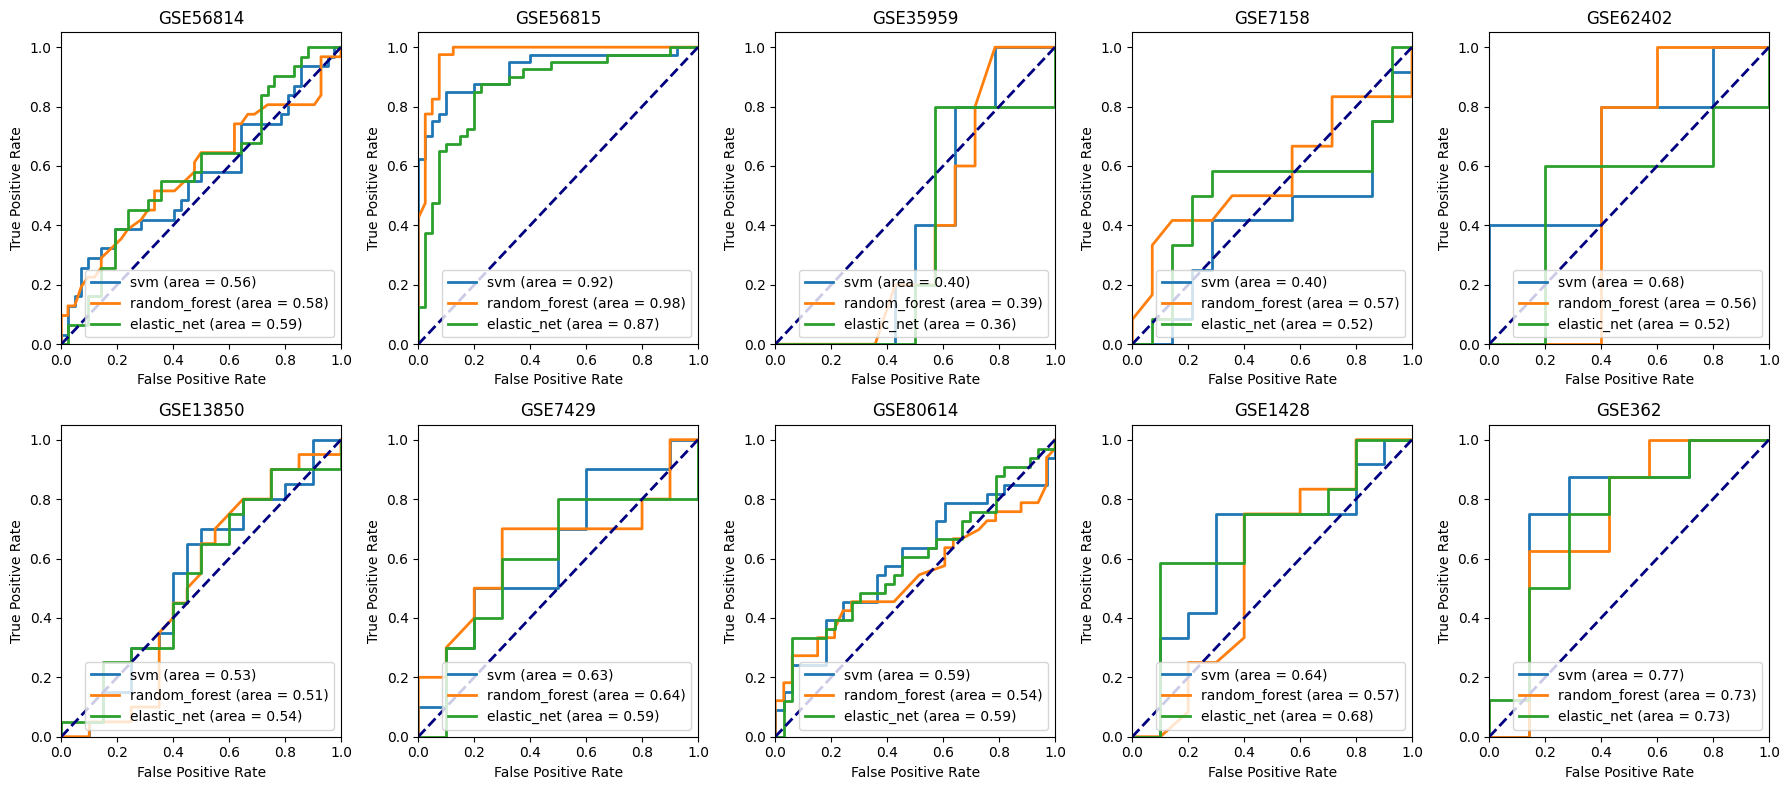

In [10]:
# 定义数据集及其名称
datasets = {
    "GSE56814": GSE56814_std_combined_data,
    "GSE56815": GSE56815_std_combined_data,
    "GSE35959": GSE35959_std_combined_data,
    "GSE7158":  GSE7158_std_combined_data,
    "GSE62402": GSE62402_std_combined_data,
    "GSE13850": GSE13850_std_combined_data,
    "GSE7429":  GSE7429_std_combined_data,
    "GSE80614": GSE80614_std_combined_data,
    "GSE1428":  GSE1428_std_combined_data,
    "GSE362":   GSE362_std_combined_data
}

# 创建绘图网格
n_datasets = len(datasets)
n_cols = 5
n_rows = (n_datasets + n_cols - 1) // n_cols  # 计算行数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))

# 将所有轴扁平化为一维数组，以便我们可以轻松地进行迭代
axes = axes.flatten()

# 遍历数据集并绘制ROC曲线
for idx, (dataset_name, std_combined_data) in enumerate(datasets.items()):
    plot_roc_curve_single_dataset(axes[idx], models, std_combined_data[hub_genes], std_combined_data['group'], dataset_name)

# 隐藏多余的子图
for i in range(n_datasets, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [11]:
# 合并数据集
combined_std_data = pd.concat([GSE35959_std_combined_data, 
                               GSE62402_std_combined_data, GSE13850_std_combined_data, 
                               GSE56815_std_combined_data, GSE56814_std_combined_data, 
                               GSE136344_std_combined_data, GSE1428_std_combined_data])
                               #GSE7429_std_combined_data, GSE362_std_combined_data, GSE7158_std_combined_data,  

# 打乱数据
combined_std_data = shuffle(combined_std_data, random_state=42)

# 选择特征和标签
X = combined_std_data[hub_genes]
y = combined_std_data['group']

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用交叉验证来评估模型性能
cv = StratifiedKFold(n_splits=5)

# 定义模型
models = {
    "random_forest": RandomForestClassifier(random_state=42),
    "gradient_boosting": GradientBoostingClassifier(random_state=42),
    "svm": SVC(probability=True, random_state=42)
    #"logistic_regression": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
}

In [12]:
combined_std_data[hub_genes]

,BCL6,DDIT4,FLNA,FOXO1,IRS1,NFKBIA,PGK1,STAT3
GSM1369771,-0.526215,-1.203593,-0.463612,-0.047104,1.144744,-0.134484,1.057344,0.076440
GSM179775,-1.365008,1.033463,-0.534029,-1.172474,-1.425502,0.331276,0.662269,-0.304998
GSM1369717,-0.313692,-0.794183,0.744050,0.154346,1.555565,0.144577,-1.311136,-0.094266
GSM4047090,-0.640785,0.241252,-0.172558,1.227440,-0.118929,1.329187,0.908462,0.453106
GSM1369711,-0.178488,0.166565,-0.456700,-0.249529,-1.661867,0.027093,-0.902415,-0.930584
...,...,...,...,...,...,...,...,...
GSM1526573,0.457181,-1.338433,0.051813,-0.488432,0.737011,0.813116,-0.104843,0.441097
GSM1369722,-2.804879,1.698665,-0.538367,1.437244,-0.670838,-0.970617,-1.864835,-1.933846
GSM1369758,-0.328376,0.167812,-0.186868,-1.101306,1.067921,0.004191,0.572974,1.066441
GSM1369793,-1.201377,0.146640,0.130163,-1.210754,-0.438213,0.522742,1.057344,0.150781


In [13]:
# 查看含有 NaN 值的行
nan_rows = combined_std_data[hub_genes][combined_std_data[hub_genes].isnull().any(axis=1)]

# 打印含有 NaN 值的行
print(nan_rows)

Empty DataFrame
Columns: [BCL6, DDIT4, FLNA, FOXO1, IRS1, NFKBIA, PGK1, STAT3]
Index: []


### what the data looks like?

In [80]:
combined_std_data = pd.concat([GSE56814_std_combined_data, GSE56815_std_combined_data, GSE35959_std_combined_data, 
                           GSE7158_std_combined_data, GSE62402_std_combined_data, GSE13850_std_combined_data,
                           GSE7429_std_combined_data])

combined_init_data = pd.concat([GSE56814_combined_data, GSE56815_combined_data, GSE35959_combined_data, 
                               GSE7158_combined_data, GSE62402_combined_data, GSE13850_combined_data,
                               GSE7429_combined_data])

In [55]:
combined_init_data

,UBA52,LYZ,S100A8,TAGLN2,ACTB,CD74,GRN,CYBB,PSAP,UBC,...,H2AC10P,MINAR1,PPIAL4A,PAH,SMG1,DYNC1LI2-DT,LOC105375061,TRAV13-1,MATCAP2,ZNF355P
GSM1369683,14.027203,14.004992,13.815787,13.303960,14.048617,13.703595,13.599704,13.510263,13.499024,13.439021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1369684,14.004992,14.204272,13.687413,13.499024,14.084373,13.815787,13.639661,13.621628,13.599704,13.553439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1369685,13.896855,13.516109,12.788743,12.593376,13.951517,13.228459,12.586058,13.040702,13.106636,13.679797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1369686,13.592743,12.642720,12.630943,13.528208,13.924998,13.040702,11.680645,11.915511,11.834666,13.351598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1369687,13.553439,12.732721,12.180579,13.238552,13.943707,13.260218,11.738531,12.295853,12.275572,13.621628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM179773,12.751497,9.588000,9.471920,10.962470,13.310564,13.039832,8.783925,9.674446,10.607958,13.195854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM179774,12.821180,10.023886,9.737605,11.055545,13.552045,13.439145,9.197839,8.848072,10.242333,13.184436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM179775,12.859296,10.437906,9.193134,11.103106,13.445442,12.970234,8.919894,9.353155,10.289874,13.133479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM179776,12.937214,10.003524,9.016865,10.858422,13.409842,13.385338,9.078113,8.189283,10.068355,13.222834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
def handle_nan(data):
    return data.dropna(axis=1)

combined_init_data = handle_nan(combined_init_data)
combined_init_data

combined_std_data  = handle_nan(combined_std_data)
combined_std_data

,UBA52,LYZ,S100A8,TAGLN2,ACTB,CD74,GRN,CYBB,PSAP,UBC,...,PRB4,RNFT1,BCHE,RLN2,VGLL3,MATN3,TF,ID2B,OR7A10,group
GSM1369683,-0.211053,0.242155,0.298116,-0.678566,0.559464,0.782687,0.270858,0.178005,0.262444,0.256455,...,-1.297516,-0.311316,0.812796,-1.084740,-1.299423,-0.651671,-0.844886,0.661787,-0.721217,0
GSM1369684,-0.274192,0.728933,0.022418,-0.241634,0.600646,1.306019,0.333403,0.404853,0.523704,0.845379,...,2.026515,-0.226975,-1.108626,-0.300873,-1.676375,-1.093624,-0.697175,-0.391942,-0.243040,0
GSM1369685,-0.581584,-0.952027,-1.907579,-2.270227,0.447630,-1.433647,-1.315781,-0.778473,-0.755790,1.495764,...,1.692135,0.546186,0.600452,-0.785998,0.298390,-0.471910,-0.226932,0.205932,1.242640,0
GSM1369686,-1.446065,-3.085432,-2.246471,-0.176264,0.417087,-2.309461,-2.733004,-3.070447,-4.056512,-0.193524,...,1.696941,0.022343,-0.468490,-0.125482,-0.071108,-0.077642,-1.220550,2.239006,-0.202486,0
GSM1369687,-1.557793,-2.865589,-3.213680,-0.825074,0.438636,-1.285503,-2.642398,-2.295705,-2.912376,1.196361,...,-0.947304,-1.389800,0.839035,-0.490289,-0.772157,0.548828,0.732681,-0.541966,-1.053556,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM179773,-1.039373,-0.720025,-0.221733,0.152354,-1.188075,-2.072318,-0.664847,1.820016,0.398596,-0.034607,...,0.824136,-0.782693,-0.660881,-0.030221,0.394660,-0.819542,-0.053591,0.906352,0.064838,1
GSM179774,0.101872,-0.230760,-0.007927,0.677523,0.202721,0.319675,0.456590,-0.546884,-0.615846,-0.168434,...,-0.101327,-0.331377,0.580245,-0.531054,-0.628720,-1.259735,-0.758934,-1.425454,0.031167,1
GSM179775,0.726123,0.233962,-0.446082,0.945881,-0.411255,-2.489226,-0.296461,0.899772,-0.483942,-0.765651,...,-0.143290,2.002661,0.319739,1.952751,-0.111874,0.023096,0.184180,-1.241108,1.401567,1
GSM179776,2.002230,-0.253616,-0.587932,-0.434727,-0.616288,-0.002645,0.132211,-2.433789,-1.098556,0.281598,...,1.826158,-0.785978,3.097490,0.410843,1.276730,-1.767035,1.318557,-0.144053,-0.601101,1


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 假设所有数据集已加载为DataFrame
# combined_data 已经是合并后的数据集

# 定义数据集名称和数据集变量
data_std_sets = [
    ("GSE56814", GSE56814_std_combined_data),
    ("GSE56815", GSE56815_std_combined_data),
    ("GSE35959", GSE35959_std_combined_data),
    ("GSE7158", GSE7158_std_combined_data),
    ("GSE62402", GSE62402_std_combined_data),
    ("GSE13850", GSE13850_std_combined_data),
    ("GSE7429", GSE7429_std_combined_data),
    ("Combined", combined_std_data)]

data_init_sets = [
    ("GSE56814", GSE56814_combined_data),
    ("GSE56815", GSE56815_combined_data),
    ("GSE35959", GSE35959_combined_data),
    ("GSE7158", GSE7158_combined_data),
    ("GSE62402", GSE62402_combined_data),
    ("GSE13850", GSE13850_combined_data),
    ("GSE7429", GSE7429_combined_data),
    ("Combined", combined_init_data)]

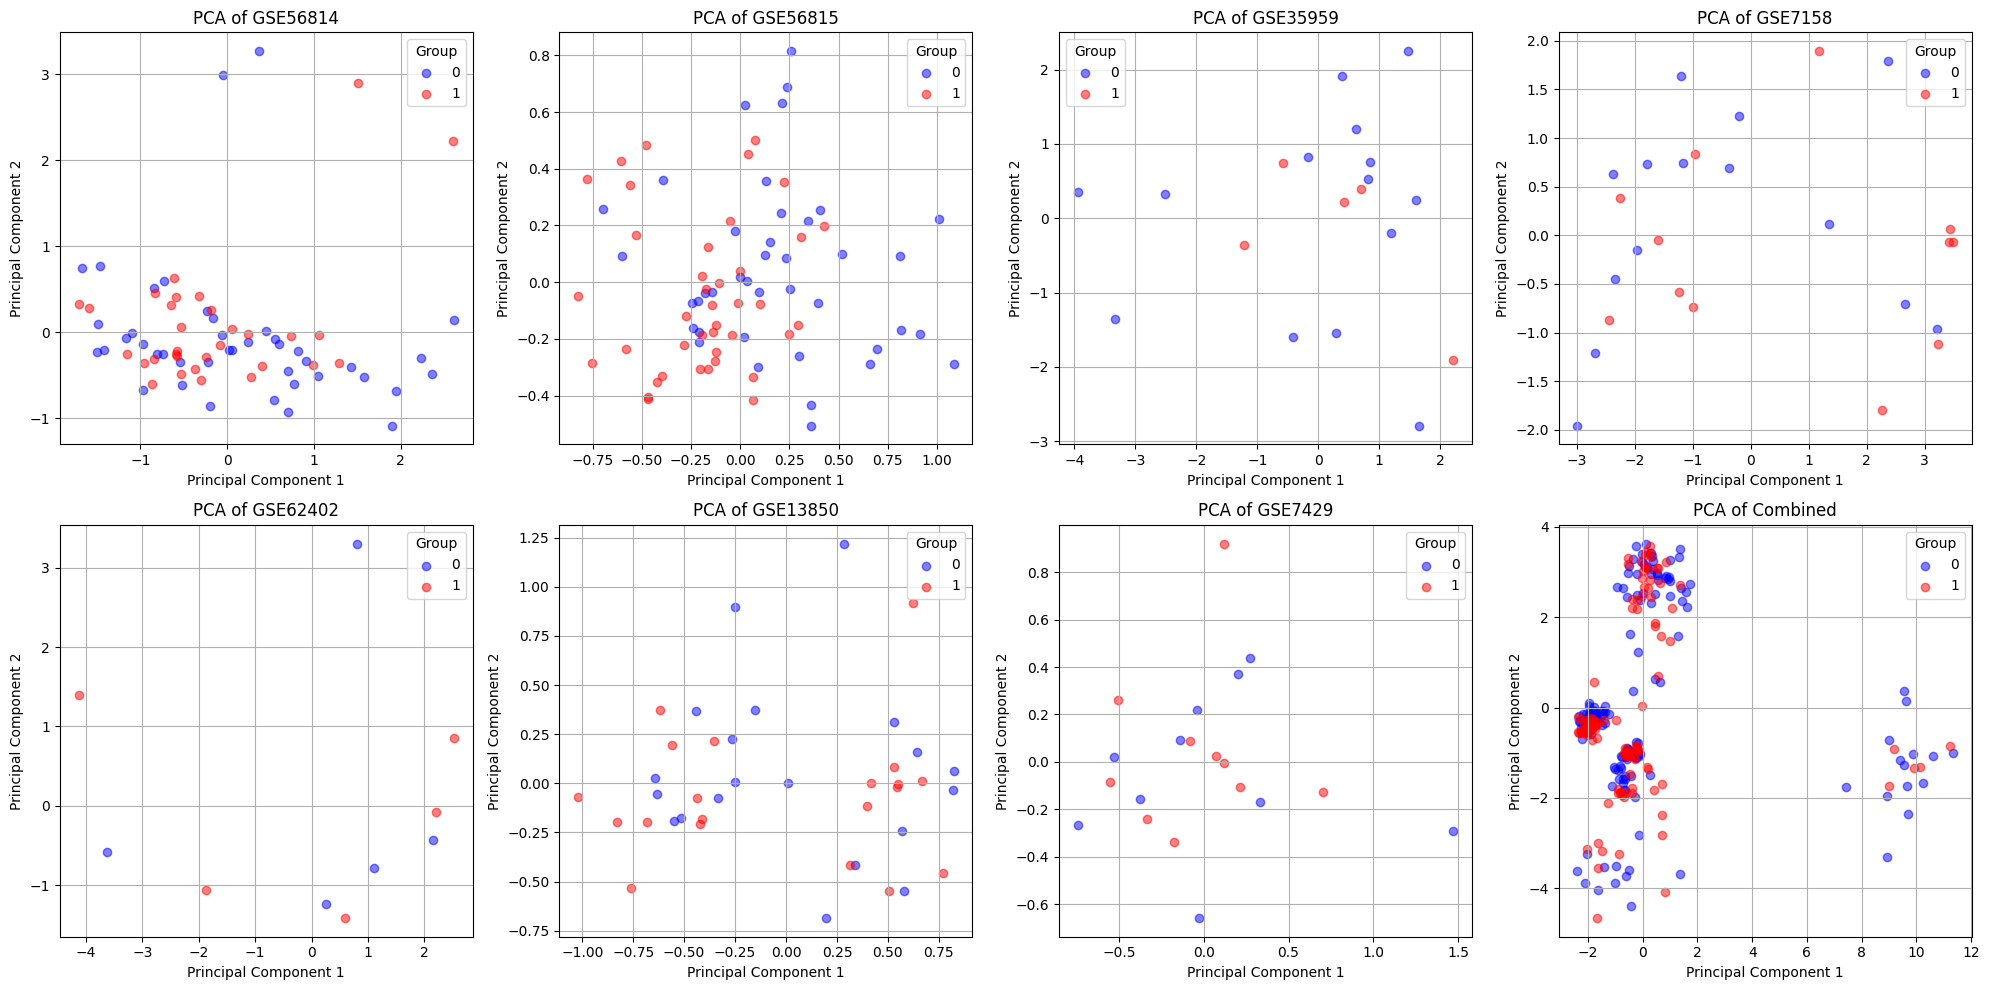

In [58]:
# 绘制每个数据集的PCA图
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for i, (title, data) in enumerate(data_init_sets):
    #X = data.iloc[:, :-1]  # 除最后一列之外的所有列
    #y = data.iloc[:, -1]   # 最后一列是标签
    X = data[hub_genes]
    y = data['group']
    
    # 进行PCA分析
    pca = PCA(n_components=2)  # 将数据降至2个主成分
    X_pca = pca.fit_transform(X)
    
    # 将PCA结果放入DataFrame
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['group'] = y.values
    
    # 绘制PCA结果
    colors = {0: 'blue', 1: 'red'}
    for label, color in colors.items():
        subset = pca_df[pca_df['group'] == label]
        axs[i].scatter(subset['PC1'], subset['PC2'], c=color, label=label, alpha=0.5)
    
    axs[i].set_title(f'PCA of {title}')
    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')
    axs[i].legend(title='Group', labels=['0', '1'])
    axs[i].grid(True)

plt.tight_layout()
plt.show()

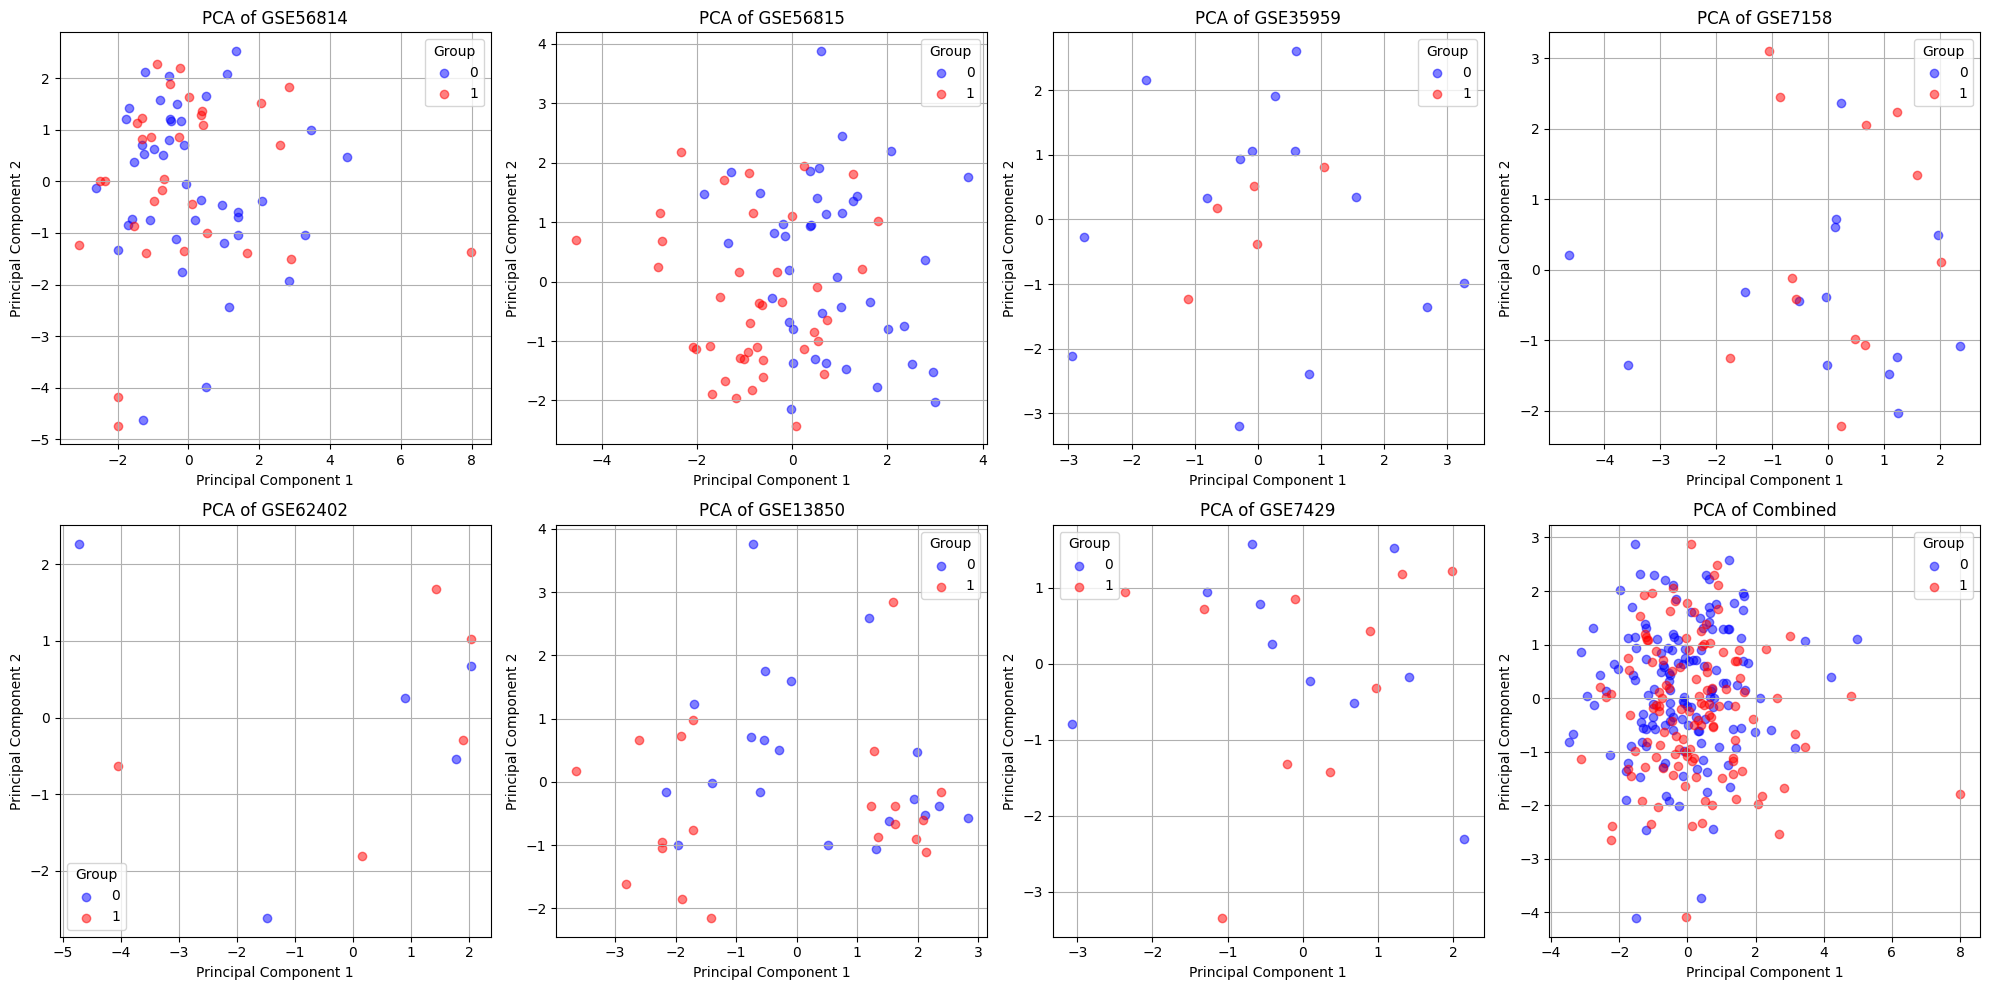

In [59]:
# 绘制每个数据集的PCA图
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for i, (title, data) in enumerate(data_std_sets):
    #X = data.iloc[:, :-1]  # 除最后一列之外的所有列
    #y = data.iloc[:, -1]   # 最后一列是标签
    X = data[hub_genes]
    y = data['group']
    
    # 进行PCA分析
    pca = PCA(n_components=2)  # 将数据降至2个主成分
    X_pca = pca.fit_transform(X)
    
    # 将PCA结果放入DataFrame
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['group'] = y.values
    
    # 绘制PCA结果
    colors = {0: 'blue', 1: 'red'}
    for label, color in colors.items():
        subset = pca_df[pca_df['group'] == label]
        axs[i].scatter(subset['PC1'], subset['PC2'], c=color, label=label, alpha=0.5)
    
    axs[i].set_title(f'PCA of {title}')
    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')
    axs[i].legend(title='Group', labels=['0', '1'])
    axs[i].grid(True)

plt.tight_layout()
plt.show()

### Train the model and validation

In [14]:
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
    print(f'{model_name} AUC: {np.mean(scores):.2f} ± {np.std(scores):.2f}')

# 在新数据集上绘制ROC曲线
def plot_roc_curve_single_dataset(models, X_new, y_new, title, ax):
    for model_name, model in models.items():
        model.fit(X_scaled, y)
        y_new_pred_prob = model.predict_proba(X_new)[:, 1]
        fpr, tpr, _     = roc_curve(y_new, y_new_pred_prob)
        roc_auc         = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves for {title}')
    ax.legend(loc="lower right")

random_forest AUC: 0.71 ± 0.07
gradient_boosting AUC: 0.72 ± 0.07
svm AUC: 0.73 ± 0.05


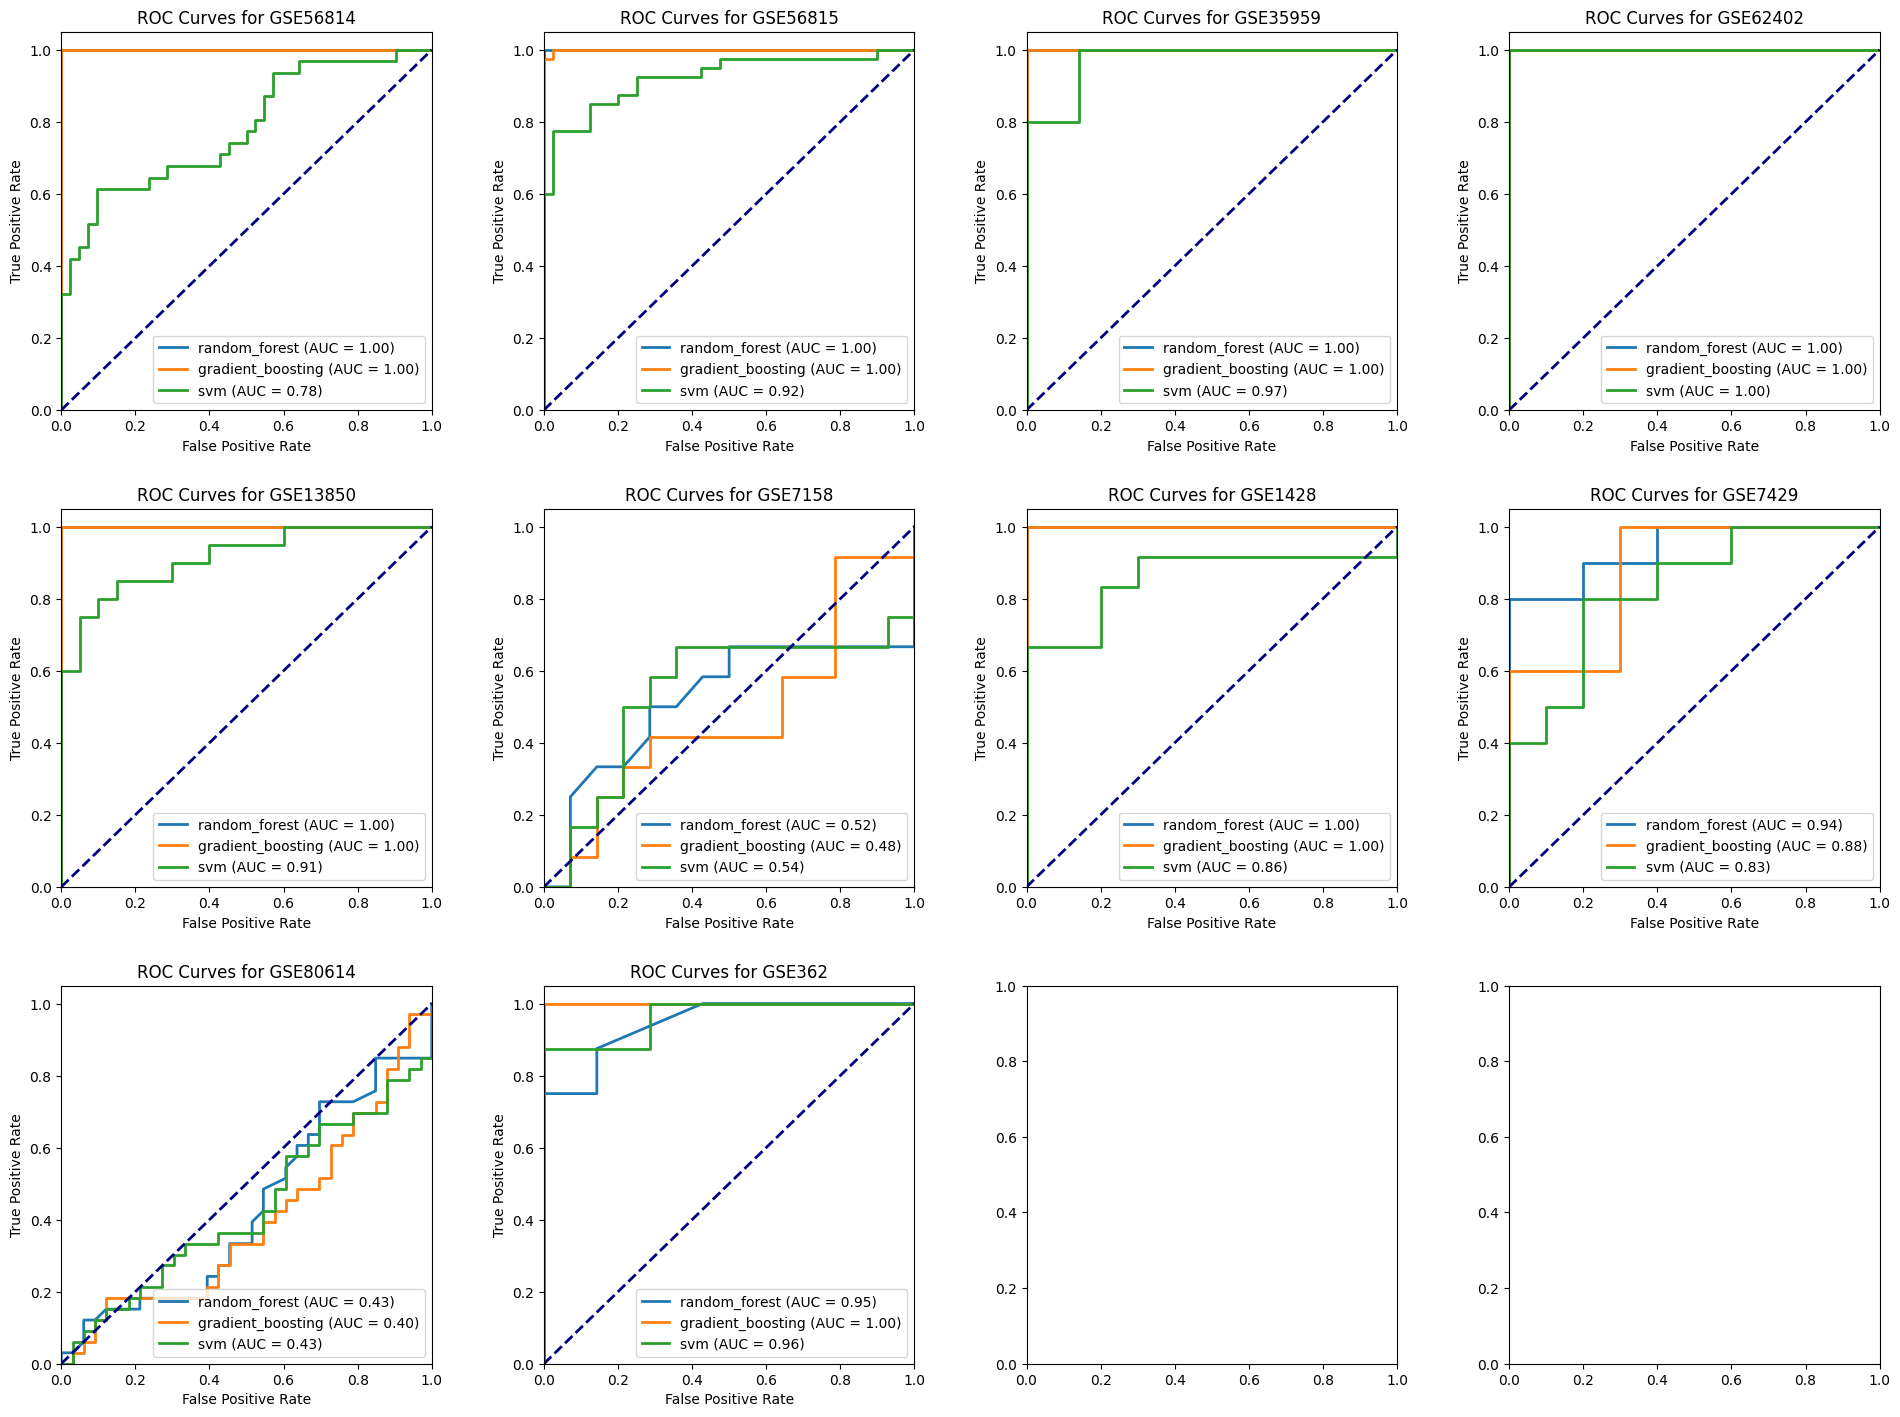

In [21]:
# 绘制不同数据集的ROC曲线
data_sets = [("GSE56814", GSE56814_std_combined_data),
            ("GSE56815",  GSE56815_std_combined_data),
            ("GSE35959",  GSE35959_std_combined_data),
            ("GSE62402",  GSE62402_std_combined_data),
            ("GSE13850",  GSE13850_std_combined_data),
            ("GSE7158",   GSE7158_std_combined_data),
            ("GSE1428",   GSE1428_std_combined_data),
            ("GSE7429",   GSE7429_std_combined_data),
            ("GSE80614",    GSE80614_std_combined_data),
            ("GSE362",    GSE362_std_combined_data)
            ] 
# ("GSE136344", GSE136344_std_combined_data),

# 创建子图
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.tight_layout(pad=5.0)

# 绘制所有数据集的ROC曲线
for i, (title, data) in enumerate(data_sets):
    row = i //4
    col = i % 4
    X_new = scaler.transform(data[hub_genes])
    y_new = data['group']
    plot_roc_curve_single_dataset(models, X_new, y_new, title, axes[row, col])
    #plot_roc_curve_single_dataset_ci(models, X_new, y_new, title, axes[row, col])

# 隐藏未使用的子图框架
if len(data_sets) % 3 != 0:
    for j in range(len(data_sets), 9):
        row = j // 3
        col = j % 3
        axes[row, col].axis('off')

plt.show()

In [22]:
output_path = os.path.join(os.getcwd(), "output_degs", "ROC_curve")
# 检查目录是否存在，如果不存在则创建
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_path

'C:\\Users\\dell\\Documents\\GitHub\\osteoporosis_sarcopenia_analysis\\output_degs\\ROC_curve'

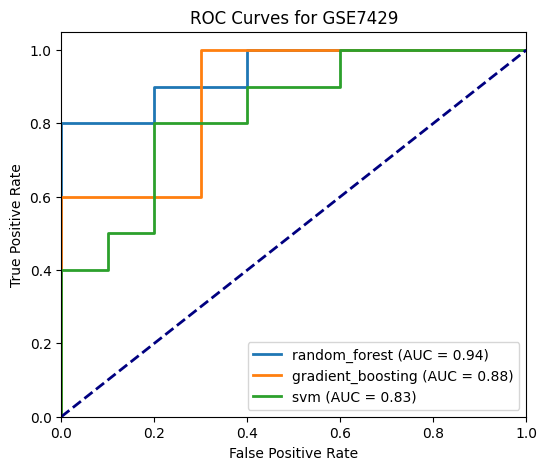

In [25]:
fig, ax = plt.subplots(figsize=(6, 5))
X_new = scaler.transform(GSE7429_std_combined_data[hub_genes])
y_new = GSE7429_std_combined_data['group']
plot_roc_curve_single_dataset(models, X_new, y_new, "GSE7429", ax)
plt.savefig(os.path.join(output_path, 'roc_curve_GSE7429.pdf'), format='pdf')
plt.show()

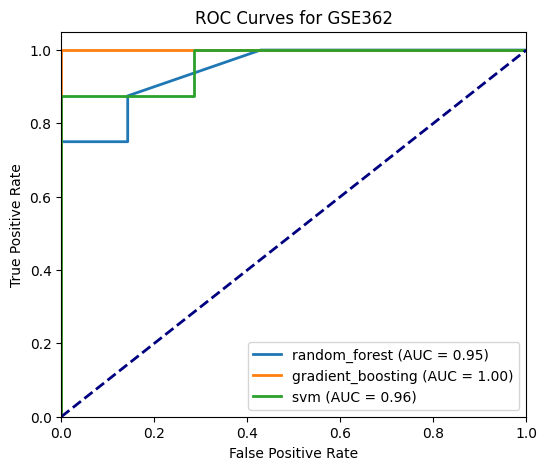

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))
X_new = scaler.transform(GSE362_std_combined_data[hub_genes])
y_new = GSE362_std_combined_data['group']
plot_roc_curve_single_dataset(models, X_new, y_new, "GSE362", ax)
plt.savefig(os.path.join(output_path, 'roc_curve_GSE362.pdf'), format='pdf')
plt.show()

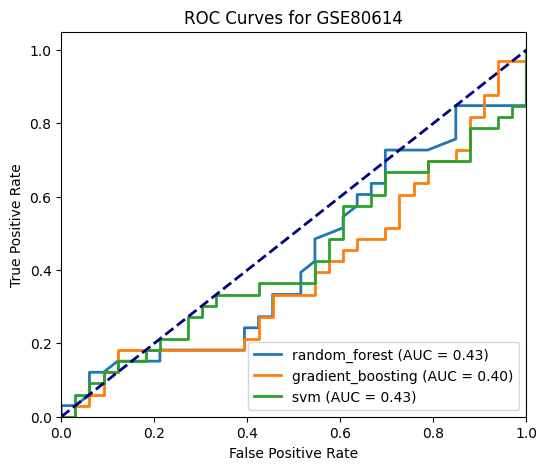

In [27]:
fig, ax = plt.subplots(figsize=(6, 5))
X_new = scaler.transform(GSE80614_std_combined_data[hub_genes])
y_new = GSE80614_std_combined_data['group']
plot_roc_curve_single_dataset(models, X_new, y_new, "GSE80614", ax)
plt.savefig(os.path.join(output_path, 'roc_curve_GSE80614.pdf'), format='pdf')
plt.show()

06/17/2024 Comments:
- The following genes were founded by RRA which integrated both OS and SA by raw P<0.05 ["BCL6", "DDIT4", "FOXO1", "IDH1", "IRS1", "NFKBIA", "PGK1", "PKM", "STAT3"]

  - By Metascape it shows that `AGE RAGE pathway` plays an important role.

- I found that these gene works well in validation on dataset GSE7429 and GSE362

- OS datasets RRA freq=3 hub_genes = ["NFKB2", "RELB", "CWC25", "MFSD10",  "ACLY", "HMGN5", "GNB2", "LAIR1", "MPPE1", "GTPBP1", "ATF1", "ZKSCAN5", "RHBDF2", "CES2"]
- These work well on validation dataset on GSE7429

06/19/2024 Comments:
- I use Venn diagram for selecting hub genes. and Finally confirmed ['BCL6', 'DDIT4', 'FLNA', 'FOXO1', 'IRS1', 'NFKBIA', 'PGK1', 'STAT3'] as the biomarker genes. Note: FOXO3 was missed by 

In [28]:
data_sets = [
    ("GSE56814", GSE56814_std_combined_data),
    ("GSE56815", GSE56815_std_combined_data),
    ("GSE35959", GSE35959_std_combined_data),
    ("GSE62402", GSE62402_std_combined_data),
    ("GSE13850", GSE13850_std_combined_data),
    ("GSE7158", GSE7158_std_combined_data),
    ("GSE7429", GSE7429_std_combined_data),
    ("GSE1428", GSE1428_std_combined_data),
    ("GSE362", GSE362_std_combined_data)
] 

# 检查FOXO3在哪些数据集中不存在
missing_foxo3 = []

for name, df in data_sets:
    if "FOXO3" not in df.columns:
        missing_foxo3.append(name)

# 打印结果
print("FOXO3不存在于以下数据集中：")
print(missing_foxo3)

FOXO3不存在于以下数据集中：
['GSE56814', 'GSE62402']


Logistic Regression: AUC = 0.91, CI 95% = [0.88, 0.94]
Random Forest: AUC = 0.93, CI 95% = [0.90, 0.96]


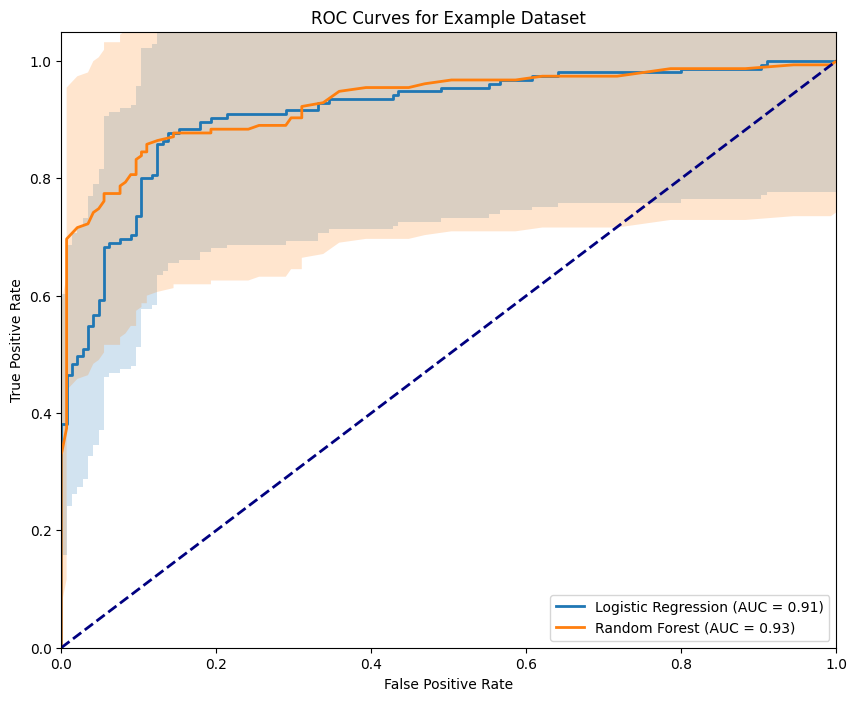

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

def plot_roc_curve_single_dateset(models, X_scaled, y, X_new, y_new, title, ax, n_bootstraps=1000, ci=95):
    for model_name, model in models.items():
        model.fit(X_scaled, y)
        y_new_pred_prob = model.predict_proba(X_new)[:, 1]
        fpr, tpr, _ = roc_curve(y_new, y_new_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Compute confidence interval
        bootstrapped_scores = []
        rng = np.random.RandomState(42)
        
        for i in range(n_bootstraps):
            # Bootstrap by sampling with replacement on the prediction indices
            indices = rng.randint(0, len(y_new_pred_prob), len(y_new_pred_prob))
            if len(np.unique(y_new[indices])) < 2:
                continue

            y_new_boot = y_new[indices]
            y_new_pred_prob_boot = y_new_pred_prob[indices]
            fpr_boot, tpr_boot, _ = roc_curve(y_new_boot, y_new_pred_prob_boot)
            roc_auc_boot = auc(fpr_boot, tpr_boot)
            bootstrapped_scores.append(roc_auc_boot)

        sorted_scores = np.array(bootstrapped_scores)
        sorted_scores.sort()

        # Compute the lower and upper bound of the confidence interval
        lower_bound = np.percentile(sorted_scores, (100 - ci) / 2)
        upper_bound = np.percentile(sorted_scores, 100 - (100 - ci) / 2)
        
        # Plot ROC curve with confidence interval shading
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        ax.fill_between(fpr, tpr - np.std(tpr), tpr + np.std(tpr), alpha=0.2)

        print(f'{model_name}: AUC = {roc_auc:.2f}, CI {ci}% = [{lower_bound:.2f}, {upper_bound:.2f}]')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves for {title}')
    ax.legend(loc="lower right")

# 示例数据集和模型定义
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 生成示例数据集
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_new = scaler.transform(X_test)

# 定义模型
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}

# 绘制ROC曲线
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve_single_dateset(models, X_scaled, y_train, X_new, y_test, 'Example Dataset', ax)
plt.show()
